In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [13]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, horizon=48, price_type=None)
df.to_pickle('/tmp/df_horizon48_price_type_none.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 12:00:00+00:00 BNB        30.722500     30.772500     30.625000   
                          BTC     10564.250000  10630.000000  10525.500000   
                          ETH       225.930000    226.440000    225.510000   
                          XRP         0.327975      0.328400      0.327000   
2019-07-20 13:00:00+00:00 BNB        30.625000     30.867500     30.335000   
...                                        ...           ...           ...   
2022-09-06 13:00:00+00:00 ETH      1663.800000   1671.400000   1637.400000   
                          LINK        7.246000      7.274500      7.130000   
                          MATIC       0.892440      0.894693      0.878533   
                          SOL        32.905000     33.072500     32.530000   
                          XRP         0.334625      0.335650      0.331325   

                                            cl        volume  \
timestamp                 symbol                               
2019-07-20 12:00:00+00:00 BNB        30.625000  2.215166e+04   
                          BTC     10539.500000  1.052997e+07   
                          ETH       225.830000  0.000000e+00   
                          XRP         0.327975  0.000000e+00   
2019-07-20 13:00:00+00:00 BNB        30.562500  1.649716e+05   
...                                        ...           ...   
2022-09-06 13:00:00+00:00 ETH      1646.000000  2.555567e+08   
                          LINK        7.168000  2.150881e+06   
                          MATIC       0.884877  4.404309e+06   
                          SOL        32.722500  1.597286e+07   
                          XRP         0.332200  9.836299e+05   

                                        execution_start_at       ret  
timestamp                 symbol                                      
2019-07-20 12:00:00+00:00 BNB    2019-07-20 13:00:00+00:00  0.009260  
                          BTC    2019-07-20 13:00:00+00:00 -0.006875  
                          ETH    2019-07-20 13:00:00+00:00 -0.017605  
                          XRP    2019-07-20 13:00:00+00:00 -0.015134  
2019-07-20 13:00:00+00:00 BNB    2019-07-20 14:00:00+00:00  0.000211  
...                                                    ...       ...  
2022-09-06 13:00:00+00:00 ETH    2022-09-06 14:00:00+00:00       NaN  
                          LINK   2022-09-06 14:00:00+00:00       NaN  
                          MATIC  2022-09-06 14:00:00+00:00       NaN  
                          SOL    2022-09-06 14:00:00+00:00       NaN  
                          XRP    2022-09-06 14:00:00+00:00       NaN  

[246688 rows x 7 columns]

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Flatten, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D,
    Concatenate, Subtract, Add, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
from sklearn.ensemble import BaggingRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetRegressor

# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y):
        for label, m in self._models:
            m.fit(X, y)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)
        

class ExampleModelRank:
    def __init__(self, symbols):
        self.max_data_sec = (7 + 4) * 24 * 60 * 60 # for predict script
        self.horizon = 48
        self.price_type = None
        self.all_symbols = symbols

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret']) - 0.5
        # df['ret_rank'] = norm.ppf(0.5 + 0.95 * df['ret_rank'])
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        
        # ridge = Ridge(fit_intercept=False, alpha=1e5)
        # lgbm = lgb.LGBMRegressor(
        #     # boosting="rf",
        #     # bagging_freq=3,
        #     # bagging_fraction=0.5,
        #     # colsample_bytree=0.3,
        #     # reg_lambda=1e7,
        #     n_estimators=1000,
        #     learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
            
        
        # self._model = TabNetRegressor()
        
        
        # self._model = BaggingRegressor(self._model, n_estimators=10, random_state=1, n_jobs=-1)
        # self._model = VotingRegressor([
        #     ('nn', self._model),
        #     ('ridge', ridge), 
        #     # ('lgbm', BaggingRegressor(lgbm, random_state=2))
        # ])
        
        df2 = df[features].unstack(level=1).fillna(0)
        df2 = df2.swaplevel(0, 1, axis=1).sort_index(axis=1)
        # display(df2)
        X = df2.values.reshape(df2.shape[0], -1, len(features))
        X = np.pad(X, ((0, 0), (0, len(self.all_symbols) - X.shape[1]), (0, 0)))
        df3 = df['ret_rank'].unstack(level=1).fillna(0)
        df3 = df3.sort_index(axis=1)
        # display(df3)
        y = df3.values
        y = np.pad(y, ((0, 0), (0, len(self.all_symbols) - y.shape[1])))
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(self.all_symbols), len(features), 0), 
        #     # batch_size=16,
        #     random_state=1,
        # )
        
        models = []
        for i in range(10):
            models.append(('nn{}'.format(i), KerasRegressor(
                model=partial(build_keras_model, len(self.all_symbols), len(features), i), 
                random_state=i
            )))
        self._model = MyVotingRegressor(models)
        
        # self._model = VotingRegressor(models)
        
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        
        self._model.fit(X, y)
        
        # self._model.fit(df[features], df['ret_rank'])
        # self._model.fit(df[features].values, df['ret_rank'].values.reshape(-1, 1), max_epochs=2)
    
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        # y_pred = self._model.predict(df[features])
        
        df2 = df[features].unstack(level=1).fillna(0)
        df2 = df2.swaplevel(0, 1, axis=1).sort_index(axis=1)
        # display(df2)
        X = df2.values.reshape(df2.shape[0], -1, len(features))
        symbol_count = X.shape[1]
        X = np.pad(X, ((0, 0), (0, len(self.all_symbols) - X.shape[1]), (0, 0)))
        
        # df['position'] = 0.0
        # for label, m in self._model._models:
        #     df3 = df['cl'].unstack(level=1).fillna(0)
        #     df3 = df3.sort_index(axis=1)
        #     # display(df3)
        #     df3.iloc[:, :] = m.predict(X)[:, :symbol_count]
        #     df3 = df3.stack()
        #     # display(df3)
        #     df['position_tmp'] = df3.loc[df.index]
        #     df['position_tmp'] = unbiased_rank(df.groupby('timestamp')['position_tmp']) - 0.5
        #     df['position'] += df['position_tmp']
        
        df3 = df['cl'].unstack(level=1).fillna(0)
        df3 = df3.sort_index(axis=1)
        # display(df3)
        df3.iloc[:, :] = self._model.predict(X)[:, :symbol_count]
        df3 = df3.stack()
        # display(df3)
        
        df['position'] = 0.0
        df['position'] = df3.loc[df.index]
        
        # df['position'] = np.sign(y_pred)
        # df['position'] = y_pred
        df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        
        def macdsignal(x, timeperiod=None):
            return talib.MACDEXT(x, fastperiod=int(timeperiod * 1.3), slowperiod=timeperiod * 3, signalperiod=i)[1]
        
        df['ln_cl'] = np.log(df['cl'])
        df['ln_volume'] = np.log(1 + df['volume'])
        
        for i in [2, 4, 8, 24, 48, 72, 96, 120]:
            df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
            # df['feature_vol_mean_{}'.format(i)] = df.groupby('symbol')['volume'].transform(lambda x: np.log(1 + x.rolling(i // 2, 1).mean()).diff(i // 2)).fillna(0)
        for i in [2, 4, 8, 24, 48, 72, 96, 120]:
            df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

            # if i <= 24:
                # df['feature_macdsignal_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: macdsignal(x, timeperiod=i)).fillna(0)
                # df['feature_macdsignal_vol_{}'.format(i)] = df.groupby('symbol')['ln_volume'].transform(lambda x: macdsignal(x, timeperiod=i)).fillna(0)
            
            # df['feature_std_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: x.rolling(i, 1).std()).fillna(0)
            
        # symbol_count = df.reset_index()['symbol'].unique().size
            
        # for col in get_feature_columns(df):
        #     # df[col + '_mean'] = df.groupby('timestamp')[col].transform('mean')
        #     df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        #     # df[col] = norm.ppf(0.5 + 0.95 * df[col])
        #     # df[col] = df[col].rolling(symbol_count * 24, 1).rank(pct=True) - 0.5
        #     # df[col + '_z'] = (df[col] - df.groupby('timestamp')[col].transform('mean')) / (1e-37 + df.groupby('timestamp')[col].transform('std').fillna(0)).fillna(0)
        #     # df[col + '_centered'] = df[col] - df.groupby('timestamp')[col].transform('mean').fillna(0)
        #     df = df.drop(columns=[col])
            
        # df = df.fillna(0)

        return df
    
# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
def build_keras_model(symbol_count, input_size, idx):
    inputs = Input(shape=(None, input_size,))
    x = inputs
    
    def mix_layer(x):
        z = GlobalAveragePooling1D()(x)
        z = Reshape((1, -1))(z)
        x = Concatenate()([
            Subtract()([x, z]),
            Add()([Subtract()([x, x]), z])
        ])
        return x
    
    # x = BatchNormalization()(x)
    x = mix_layer(x)
    
    # for i in range(1 + (idx % 3)):
    for i in range(3):
        x = Dense(64, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = mix_layer(x)
    
    x = Dense(1, activation='linear', use_bias=True)(x)
    model = Model(inputs=inputs, outputs=x)
    # opt = 'sgd'
    opt = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  metrics=[])
    return model

def calc_pos(x, th):
    pos = x.copy() * 0.0
    p = 0.0
    for i in range(x.shape[0]):
        if x.iloc[i] > th:
            p = 1.0
        elif x.iloc[i] < -th:
            p = -1.0
        pos.iloc[i] = p
    return pos
    
def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

2022-09-06 14:49:40.405991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 14:49:40.406052: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-09-06 14:49:46.398114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-06 14:49:46.398175: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-06 14:49:46.398206: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (909ed3e2d727): /proc/driver/nvidia/version does not exist
2022-09-06 14:49:46.398489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


172/172 [==============================] - 1s 6ms/step
return without cost statistics
mean 0.004256668376588606
std 0.025926929951101046
sharpe 0.16417942211502895
max drawdown 0.420775287247394
return with cost statistics
mean 0.003414817030480425
std 0.025943750144583274
sharpe 0.13162387902480613
max drawdown 0.420455287247394


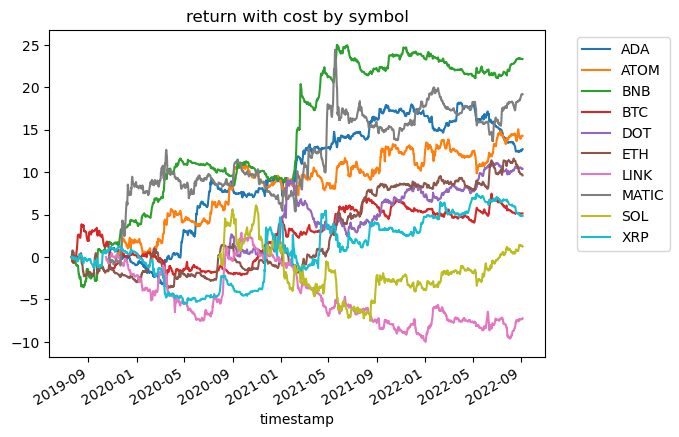

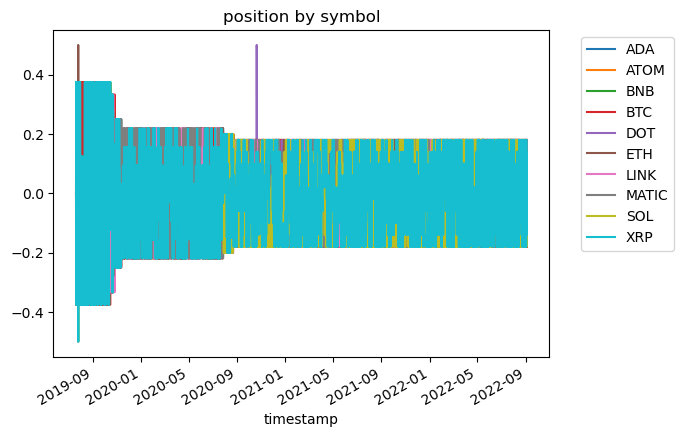

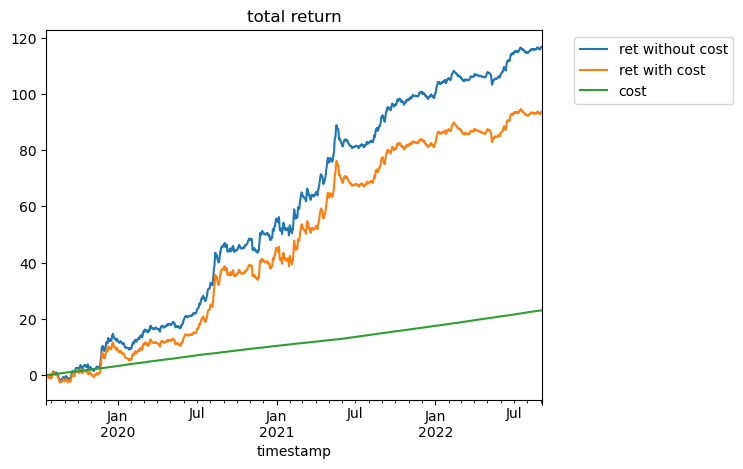

857/857 [==============================] - 10s 9ms/step - loss: 0.0955
INFO:tensorflow:Assets written to: ram:///tmp/tmpjcfiyqwe/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmph4pwaa5q/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp1nwghkoq/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmphk_zged8/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpgcdbrlpd/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpowvr8ex5/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpztyyh83d/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpgrl4808h/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp9czikf4e/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp5ew_o4of/assets


In [3]:
df = pd.read_pickle('/tmp/df_horizon48_price_type_none.pkl')

model = ExampleModelRank(df.reset_index()['symbol'].unique().tolist())

# cv
calc_position_cv(model, df)
visualize_result(df.dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20220906_nn_portfolio2.xz', 'wb') as f:
    f.write(data)

9/9 [==============================] - 0s 3ms/step
timestamp                  symbol
2022-08-26 13:00:00+00:00  ADA       0.00
                           ATOM      0.00
                           BNB       0.00
                           BTC       0.00
                           DOT       0.00
                                     ... 
2022-09-06 13:00:00+00:00  ETH       0.18
                           LINK     -0.06
                           MATIC     0.02
                           SOL       0.14
                           XRP       0.06
Name: position, Length: 2650, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict
9/9 [==============================] - 0s 3ms/step


position1  position2  position3
timestamp                 symbol                                 
2022-08-26 14:00:00+00:00 ADA          0.00       0.00       0.00
                          ATOM         0.00       0.00       0.00
                          BNB          0.00       0.00       0.00
                          BTC          0.00       0.00       0.00
                          DOT          0.00       0.00       0.00
...                                     ...        ...        ...
2022-09-06 12:00:00+00:00 ETH          0.18       0.18       0.18
                          LINK        -0.02      -0.02      -0.02
                          MATIC        0.06       0.06       0.06
                          SOL          0.14       0.14       0.14
                          XRP          0.10       0.10       0.10

[2630 rows x 3 columns]

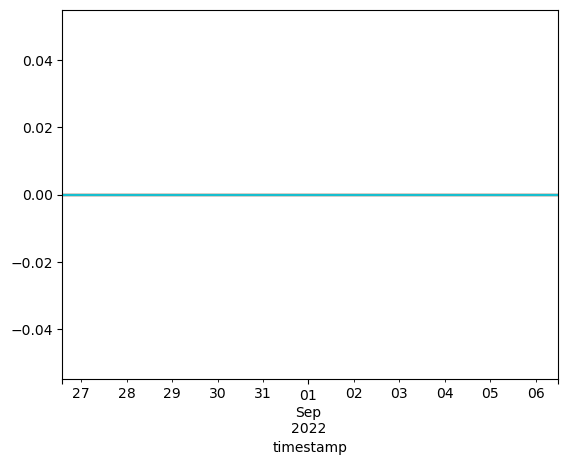

ADA (263, 4)
ATOM (263, 4)
BNB (263, 4)
BTC (263, 4)
DOT (263, 4)
ETH (263, 4)
LINK (263, 4)
MATIC (263, 4)
SOL (263, 4)
XRP (263, 4)


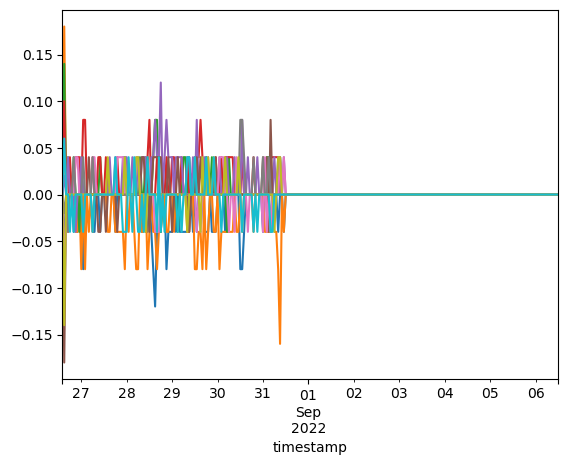

ADA (265, 3)
ATOM (265, 3)
BNB (265, 3)
BTC (265, 3)
DOT (265, 3)
ETH (265, 3)
LINK (265, 3)
MATIC (265, 3)
SOL (265, 3)
XRP (265, 3)


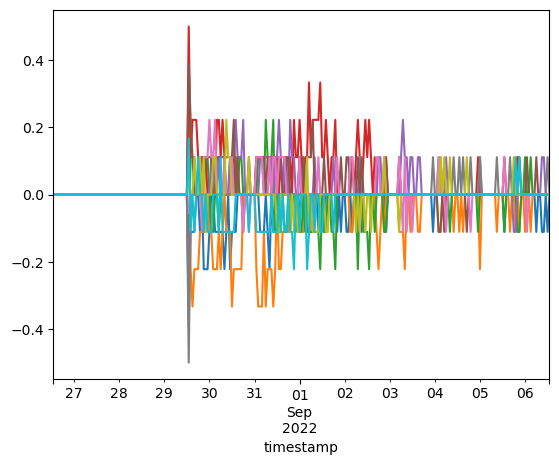

In [4]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20220906_nn_portfolio2.xz')
df = pd.read_pickle('/tmp/df_horizon48_price_type_none.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

def _calc_features(df):        
    df = df.copy()

    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

    for col in get_feature_columns(df):
        df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

    return df

df_features1 = _calc_features(df)
df_features3 = _calc_features(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

df_test2 = pd.concat([
    df_features1['feature_rsi_72'].rename('feature1'),
    df_features3['feature_rsi_72'].rename('feature3'),
    # df_features1['feature_momentum_72'].rename('feature1'),
    # df_features3['feature_momentum_72'].rename('feature3'),
], axis=1)

for symbol, df_symbol in df_test2.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['feature3'] - df_symbol['feature1']).plot()
plt.show()